**Данные:** Представленные данные отображают поведение 8950 активных держателей кредитных карт за последние 6 месяцев. В датасете представлены 18 подведенческих признаков клиента.

**Задача:** Необходимо разработать сегментацию клиентов для определения маркетинговой стратегии.

**Подробнее о данных:** https://www.kaggle.com/datasets/arjunbhasin2013/ccdata
**Статья по теме:** https://realpython.com/k-means-clustering-python/  

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import adjusted_rand_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler, normalize, PowerTransformer
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan

1. Необходимо загрузить данные. Изучить признаки, представленные в датасете. Определить какой тип признаков (категориальные, текстовые, числовые). Определить, есть ли в датасете пропуски, если есть, то по одной из стратегий произвести  чистку данных.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

table = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/GENERAL.csv')

Mounted at /content/drive/


In [ ]:
table.tail()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
8945,C19186,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,325.594462,48.886365,0.50,6
8946,C19187,19.183215,1.000000,300.00,0.00,300.00,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,275.861322,NaN,0.00,6
8947,C19188,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5,1000.0,81.270775,82.418369,0.25,6
8948,C19189,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,2,0,500.0,52.549959,55.755628,0.25,6
8949,C19190,372.708075,0.666667,1093.25,1093.25,0.00,127.040008,0.666667,0.666667,0.000000,0.333333,2,23,1200.0,63.165404,88.288956,0.00,6


In [ ]:
colnames = list(table.columns)
for c in colnames:
  if len(list(table[c].unique()))<=10:
    print(c,"contains categorial data")
  else:
    try:
      map(float, table[c])
      print(c,"contains numerical data")
    except ValueError:
      print(c,"contains text data")

CUST_ID contains numerical data
BALANCE contains numerical data
BALANCE_FREQUENCY contains numerical data
PURCHASES contains numerical data
ONEOFF_PURCHASES contains numerical data
INSTALLMENTS_PURCHASES contains numerical data
CASH_ADVANCE contains numerical data
PURCHASES_FREQUENCY contains numerical data
ONEOFF_PURCHASES_FREQUENCY contains numerical data
PURCHASES_INSTALLMENTS_FREQUENCY contains numerical data
CASH_ADVANCE_FREQUENCY contains numerical data
CASH_ADVANCE_TRX contains numerical data
PURCHASES_TRX contains numerical data
CREDIT_LIMIT contains numerical data
PAYMENTS contains numerical data
MINIMUM_PAYMENTS contains numerical data
PRC_FULL_PAYMENT contains numerical data
TENURE contains categorial data


In [ ]:
table.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [ ]:
table["MINIMUM_PAYMENTS"] = table["MINIMUM_PAYMENTS"].fillna(table["MINIMUM_PAYMENTS"].mean())
table["CREDIT_LIMIT"] = table["CREDIT_LIMIT"].fillna(table["CREDIT_LIMIT"].mean())
table = table.drop('CUST_ID', axis=1)

2. Построить графики распределения для каждого признака (библиотека seaborn - sns.displot / plt.hist) и сделать вывод о характере распределения. Подсказка: в большинстве признаков распределение экспоненциальное. Эффективным подходом к переходу от экпоненциального к нормальному распределению - логарифмирование значений признака.

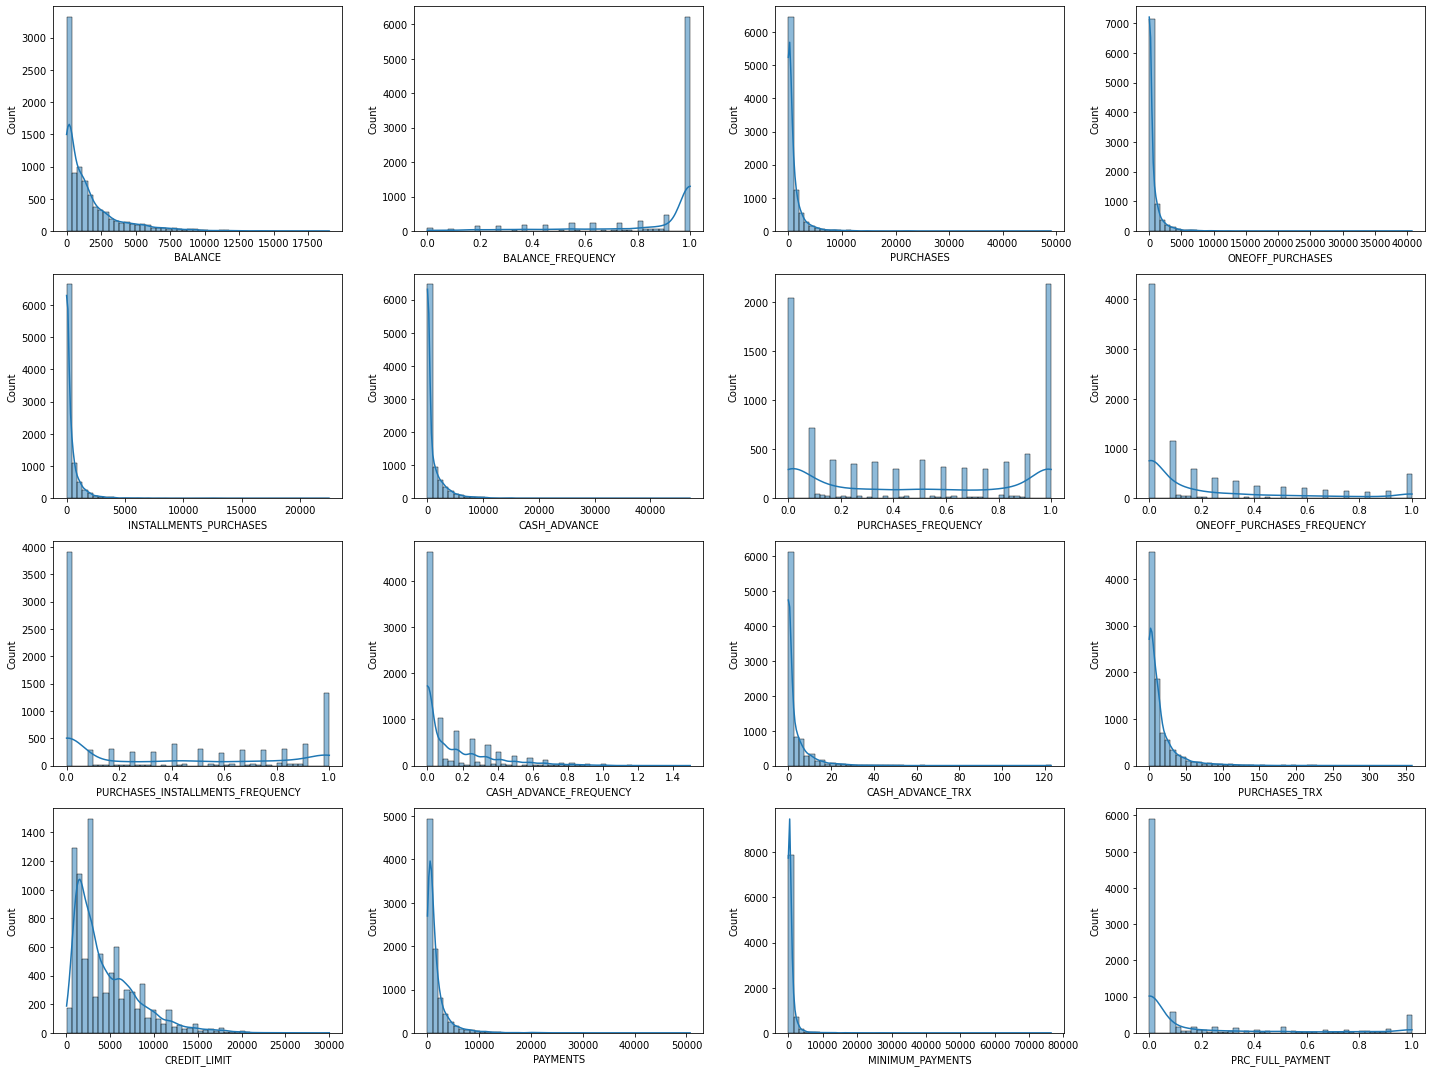

In [ ]:
def plot_histograms(dataset):
    fig, ax = plt.subplots(4,4, figsize = (20,15))

    for feature, subplot in zip(dataset, ax.flatten()):
        h = sns.histplot(dataset[feature], bins = 50, ax = subplot,kde = True)
    plt.tight_layout()

plot_histograms(table)

3. Необходимо отнормировать признаки. Для числовых - по одной из стратегий (MinMax, StandartScaler и др.). Для категориальных - применить LabelEncoder / OneHotEncoder.

In [ ]:
colnames = ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 
            'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 
            'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
            'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 
            'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT']


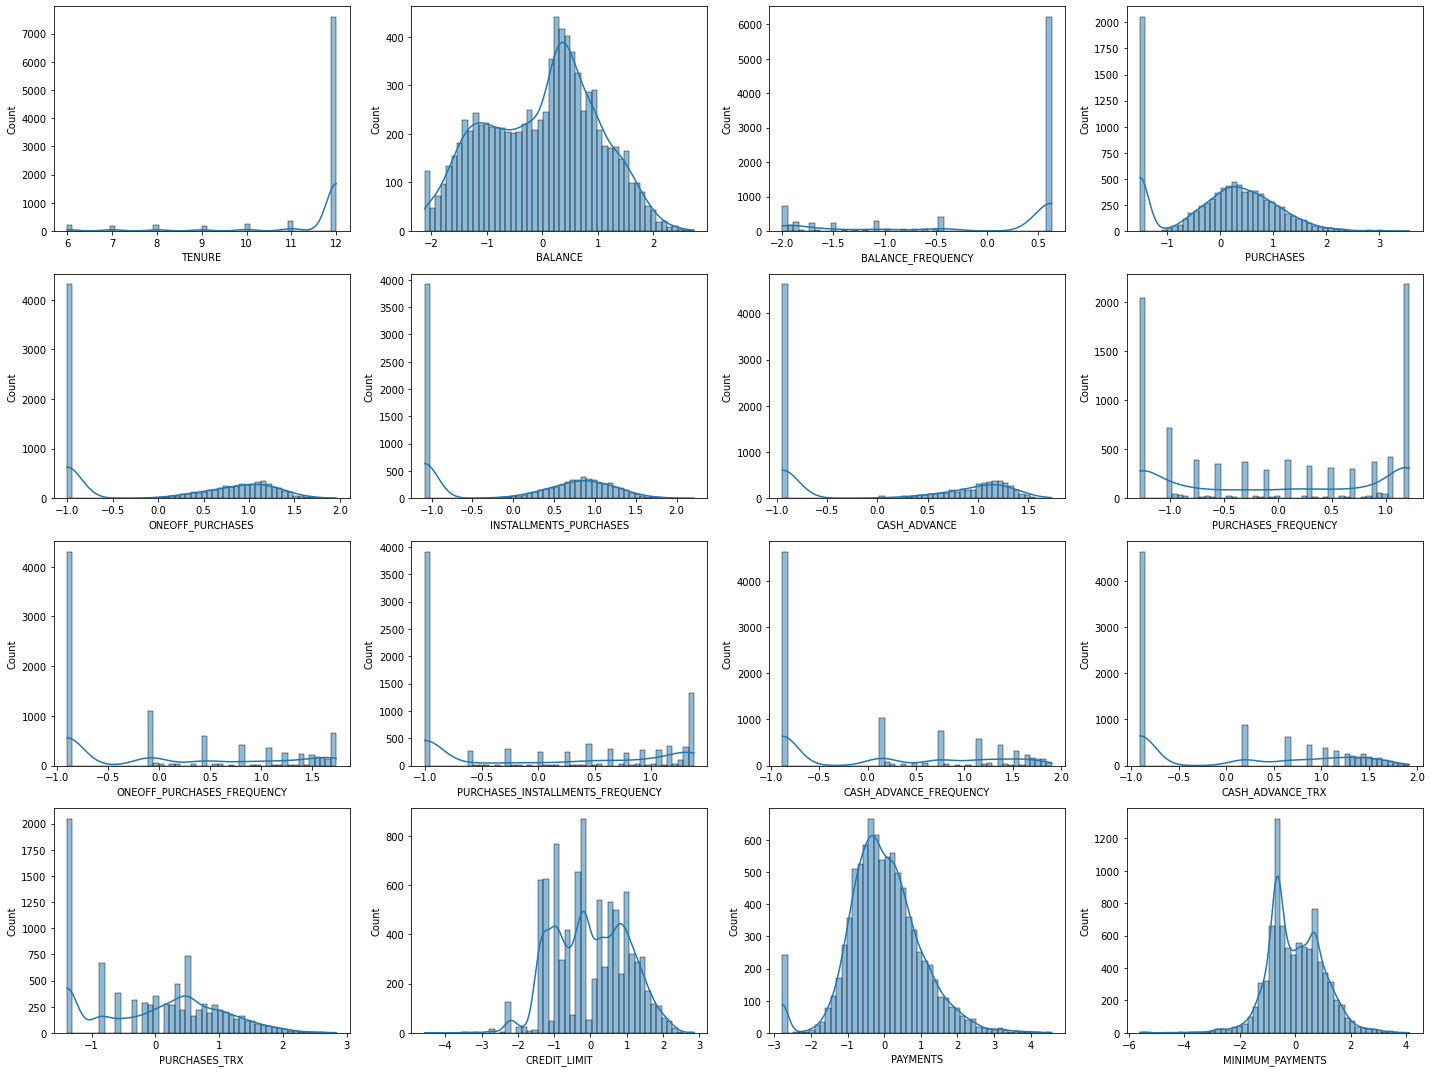

In [ ]:
def normalize_dataset(dataset, num_cols : list):
  # keep only umerical columns to be normalized
  data = dataset[num_cols] 
  # drop those columns from original dataset
  dataset = dataset.drop(columns= num_cols)
  vals = data.values
  #scaler = StandardScaler()
  scaler = PowerTransformer()
  scaled = scaler.fit_transform(vals)
  # creating dataframe with normalized data 
  #scaled_df = pd.DataFrame(scaled, columns = num_cols)
  # Normalizing the Data 
  # normalized = normalize(scaled_df) 
  # Converting the numpy array into a pandas DataFrame 
  normalized = pd.DataFrame(scaled,columns=num_cols)
  # adding those columns to our original dataframe
  normalized = pd.concat([dataset, normalized],axis=1)

  return normalized

newtable = normalize_dataset(table,colnames)
newtable.head()
plot_histograms(newtable)

4. С помощью алгоритмов понижения размерности (PCA, LDA, T-SNE и др.) необходимо отобразить все признаки в двумерном виде. Выбрать лучшее представление (кластеры могут быть различимы).

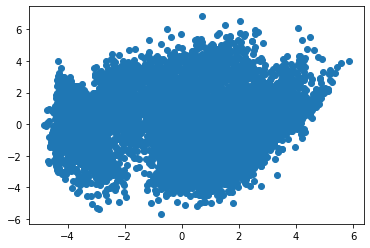

In [ ]:
# kernel pca decomposition
kpca = KernelPCA(n_components=2)
kpcadf = kpca.fit_transform(newtable)

x, y = kpcadf[:,0], kpcadf[:,1]
plt.scatter(x,y)
plt.show()

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 8950 samples in 0.000s...
[t-SNE] Computed neighbors for 8950 samples in 2.012s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8950
[t-SNE] Computed conditional probabilities for sample 2000 / 8950
[t-SNE] Computed conditional probabilities for sample 3000 / 8950
[t-SNE] Computed conditional probabilities for sample 4000 / 8950
[t-SNE] Computed conditional probabilities for sample 5000 / 8950
[t-SNE] Computed conditional probabilities for sample 6000 / 8950
[t-SNE] Computed conditional probabilities for sample 7000 / 8950
[t-SNE] Computed conditional probabilities for sample 8000 / 8950
[t-SNE] Computed conditional probabilities for sample 8950 / 8950
[t-SNE] Mean sigma: 0.708476


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.576736
[t-SNE] KL divergence after 1000 iterations: 1.093194


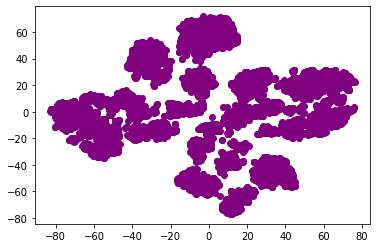

In [ ]:
tsne = TSNE(n_components = 2, verbose = 1, perplexity = 50, 
              n_iter = 1000, learning_rate = 200, init = 'pca')
tsne_df = tsne.fit_transform(newtable)
tsne_df = pd.DataFrame(tsne_df, columns = ['C1', 'C2'])
plt.scatter(tsne_df["C1"],tsne_df["C2"], c="purple")
plt.show()


5. С помощью стастистики Хопкинса рассчитать тенденцию к кластеризации. Сделать вывод о тенденции.
<br> Значение статистики можно интерпретировать как:
* значения между {0.01, ...,0.3} — данные “разнесены” по пространству
* значения около 0.5 — данные случайные
* значения между {0.7, ..., 0.99} — в данных наблюдается кластерная тенденция
<br> Подробнее https://github.com/prathmachowksey/Hopkins-Statistic-Clustering-Tendency/blob/master/Hopkins-Statistic-Clustering-Tendency.ipynb

In [ ]:
def hopkins(dataset):
    d = dataset.shape[1]
    # d = len(vars) # columns
    n = len(dataset)  # rows
    m = int(0.1 * n)  
    neighbors = NearestNeighbors(n_neighbors=1).fit(dataset.values)
    rand = sample(range(0, n, 1), m)
    ujd = []
    wjd = []
    for j in range(0, m):
        #u_dist = nearest neighbour distances from uniform random sample
        u_dist, _ = neighbors.kneighbors(uniform(np.amin(dataset, axis=0), np.amax(dataset, axis=0), d).reshape(1, -1), 2,
                                    return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = neighbors.kneighbors(dataset.iloc[rand[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
    return H

hopkins(newtable) # в данных наблюдается кластерная тенденция

0.8531628542871452

6. На алгоритмах кластеризации (KMeans, Birch, GaussianMixture, AgglomerativeClustering и др.) необходимо обучить модели, получить лейблы(лейблы = модель.fit_transform(...)). Количество кластеров необходимо подобрать. 
<br> При помощи перебора в каждом алгоритме необходимо найти оптимальное число кластеров:
<br> 1) С помощью метрик silhouette_score (max значение оптимальное), davies_bouldin_score (min значние оптимальное), calinski_harabasz_score (max значение оптимальное) вычислить значение для каждого алгоритма и числа кластеров.
<br> 2) Отобразить графики значения метрик от количества кластеров. 
<br> 3) Выбрать оптимальное число кластеров.
<br> 4) Обучить модели с учетом выбранного числа кластеров.
<br> 5) По полученным лейблам и двумерном представлении данных (пункт 4) визуализировать точки (plt.scatter(..., c=лейблы, cmap='tab20'))
<br> Подробнее о метриках: https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Clustering-Dimensionality-Reduction/Clustering_metrics.ipynb

**KMeans**

In [ ]:
def metrics_visual(dataset,scoretype:str, modelname = "KMeans")->list:
      coeffs = []
      p = True
      for k in range(2, 16):
          if modelname == "KMeans":
            model = KMeans(n_clusters=k)
            model.fit(dataset)
          if modelname == "Agglomerative Clustering":
            model = AgglomerativeClustering(n_clusters = k)
            model.fit_predict(dataset)

          if scoretype == "Silhouette":
            score = silhouette_score(dataset, model.labels_)
            coeffs.append(score)
          elif scoretype == "Davies Bodulin":
            score = davies_bouldin_score(dataset, model.labels_)
            coeffs.append(score)
          elif scoretype == "Calinski Harabazs":
            score = calinski_harabasz_score(dataset, model.labels_)
            coeffs.append(score)
          else:
            print("Wrong scoretype")
            p = False
      if p: 
        plt.style.use("fivethirtyeight")
        plt.plot(range(2, 16), coeffs)
        plt.xticks(range(2, 16))
        plt.xlabel("Number of Clusters")
        plt.ylabel(scoretype)
        plt.show()
      return coeffs

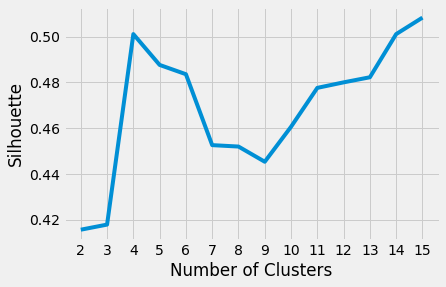

Best coeff is: 0.50825083
Corresponding number of clusters: 15


In [ ]:
scoeffs = metrics_visual(tsne_df, "Silhouette")
best_s = max(scoeffs)
print("Best coeff is:", best_s)
print("Corresponding number of clusters:",scoeffs.index(best_s)+2)

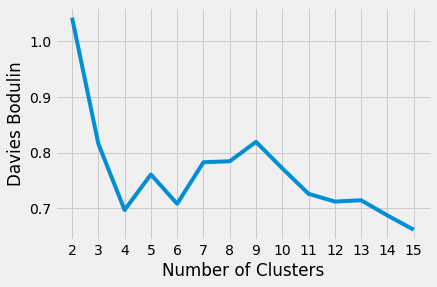

Best coeff is: 0.6614447564370692
Corresponding number of clusters: 15


In [ ]:
dcoeffs = metrics_visual(tsne_df, "Davies Bodulin")
best_d = min(dcoeffs)
print("Best coeff is:", best_d)
print("Corresponding number of clusters:",dcoeffs.index(best_d)+2)

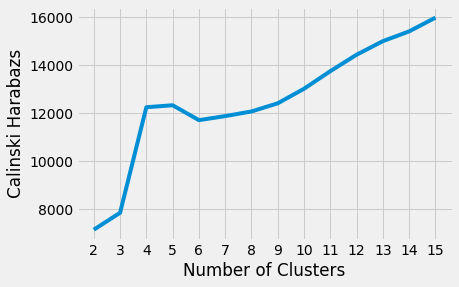

Best coeff is: 15985.024273754276
Corresponding number of clusters: 15


In [ ]:
ccoeffs=metrics_visual(tsne_df, "Calinski Harabazs")
best_c = max(ccoeffs)
print("Best coeff is:", best_c)
print("Corresponding number of clusters:",ccoeffs.index(best_c)+2)

**Agglomerative Clusetring**

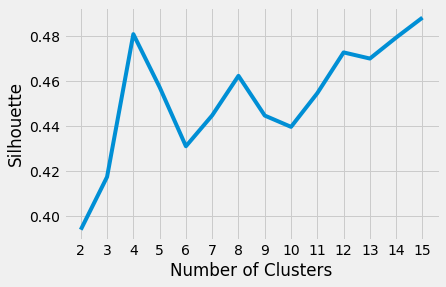

Best coeff is: 0.48819533
Corresponding number of clusters: 15


In [ ]:
scoeffs = metrics_visual(tsne_df, "Silhouette", "Agglomerative Clustering")
best_s = max(scoeffs)
print("Best coeff is:", best_s)
print("Corresponding number of clusters:",scoeffs.index(best_s)+2)

**Elbow Method** to choose number of clusters

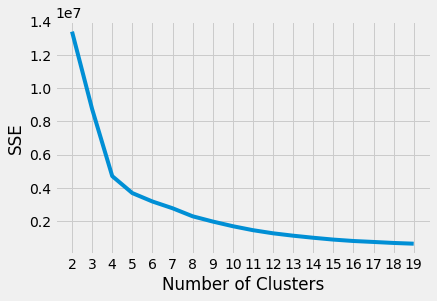

In [ ]:
def elbow(modelname, dataset):
    sse = []
    for k in range(2, 20):
        if modelname == "KMeans":
          kmeans = KMeans(n_clusters=k)
          kmeans.fit(dataset)
          sse.append(kmeans.inertia_)

    plt.style.use("fivethirtyeight")
    plt.plot(range(2, 20), sse)
    plt.xticks(range(2, 20))
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.show()
    return sse

ekmeans = elbow("KMeans", tsne_df)

In [ ]:
!apt-get -qq install -y graphviz && pip install kneed
from kneed import KneeLocator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
kl = KneeLocator(range(2, 20), ekmeans, curve="convex", direction="decreasing")
kl.elbow

5

In [ ]:
def make_groups(modelname:str, dataset, clustnum=15):

  if modelname == "KMeans":
    model= KMeans(clustnum)
    model.fit_transform(dataset)

  elif modelname == "Agglomerative Clustering":
    model = AgglomerativeClustering(clustnum)
    model.fit(dataset)

  elif modelname == "DBSCAN":
    model = DBSCAN(eps=3.9, min_samples = 21)
    model.fit(dataset)
    n_clust = len(set(model.labels_)) - (1 if -1 in model.labels_ else 0)
    noisepoints = list(model.labels_).count(-1)
    print('Number of clusters:', n_clust)
    print('Number of noise points:', noisepoints)
  
  labels=model.labels_
  clusters=pd.concat([dataset, pd.DataFrame({'cluster':labels})], axis=1)
  #tsne = TSNE(n_components = 2, verbose = 1, perplexity = 50, 
  #            n_iter = 1000, learning_rate = 200, init = 'pca')
  #tsne_df = tsne.fit_transform(clusters)
  x = dataset["C1"]
  y = dataset["C2"]
  # group by clustrs
  df_clusters = pd.DataFrame({'x': x, 'y':y, 'label':labels}) 
  groups = df_clusters.groupby('label')
  return groups


def visualize(groups, colors, names, title):
  fig, ax = plt.subplots(figsize=(10, 13)) 

  for name, group in groups:
      ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
              color=colors[name],label=names[name], mec='none') 
  ax.legend()
  ax.set_title(title)
  plt.show()


In [ ]:
colors = {-1:'pink',0: 'green',1: 'blue',2: 'yellow',3:'orange',4:'purple',5:'red',
          6:'black',7:'brown',8:'cyan',9:'magenta',10:'#615151',
          11:'#3eb384', 12:'#73650e', 13:'#730e42',14:'#ff63b4'}

lbls = {-1:'C-1', 0: 'Cl1', 1: 'Cl2', 2: 'Cl3',3:'Cl4',4:'Cl5',5:'Cl6',
        6:'Cl7',7:'Cl8',8:'Cl9',9:'Cl10',10:'Cl11',
        11:'Cl12',12:'Cl13',13:'Cl14',14:'Cl15'}

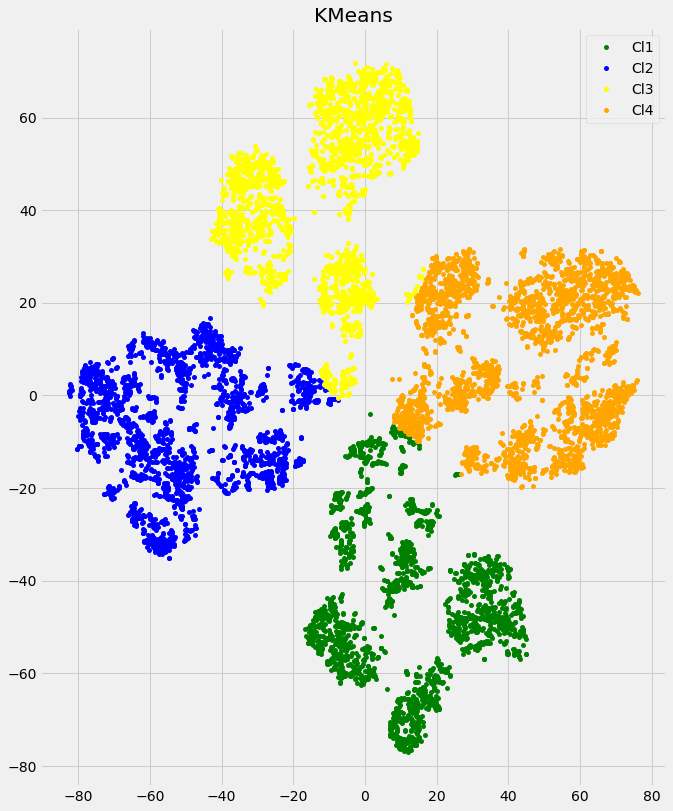

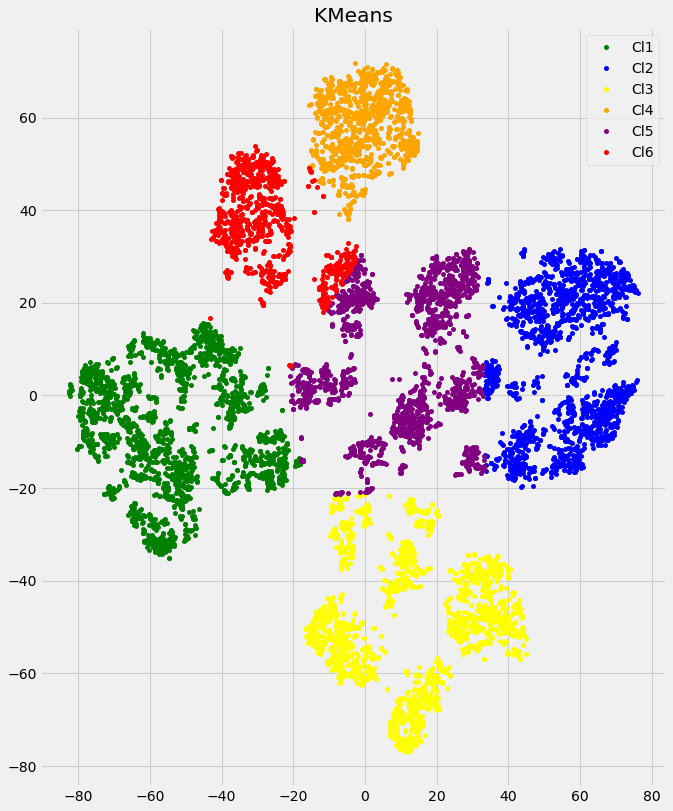

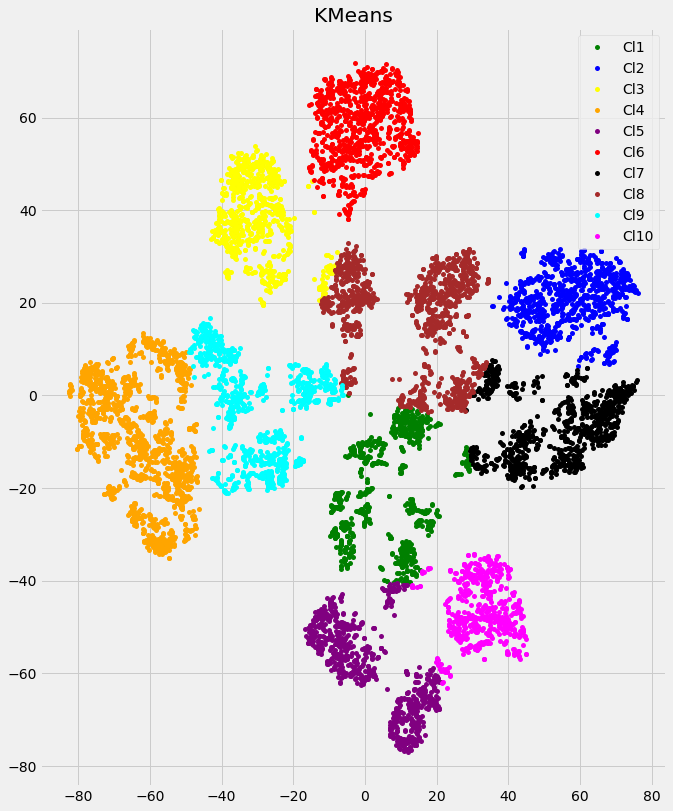

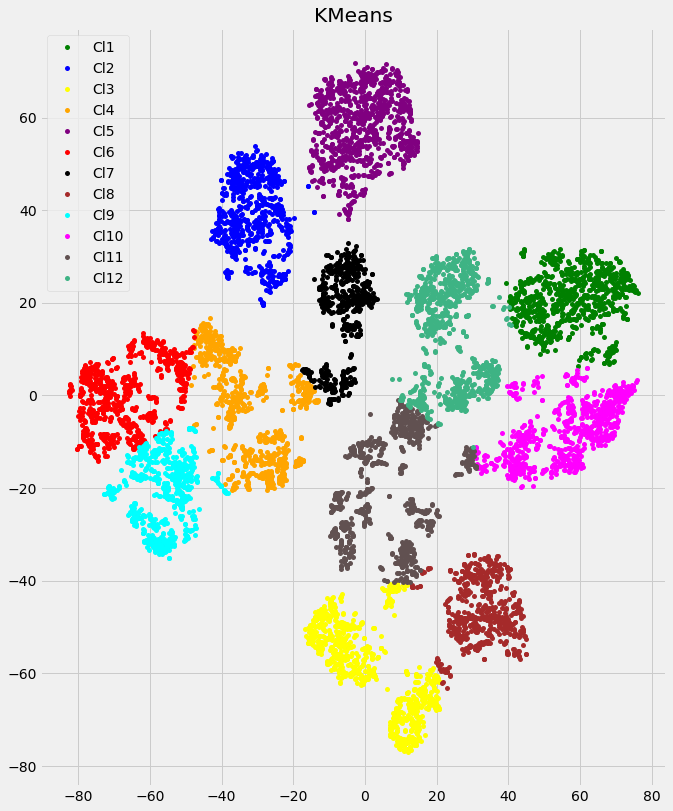

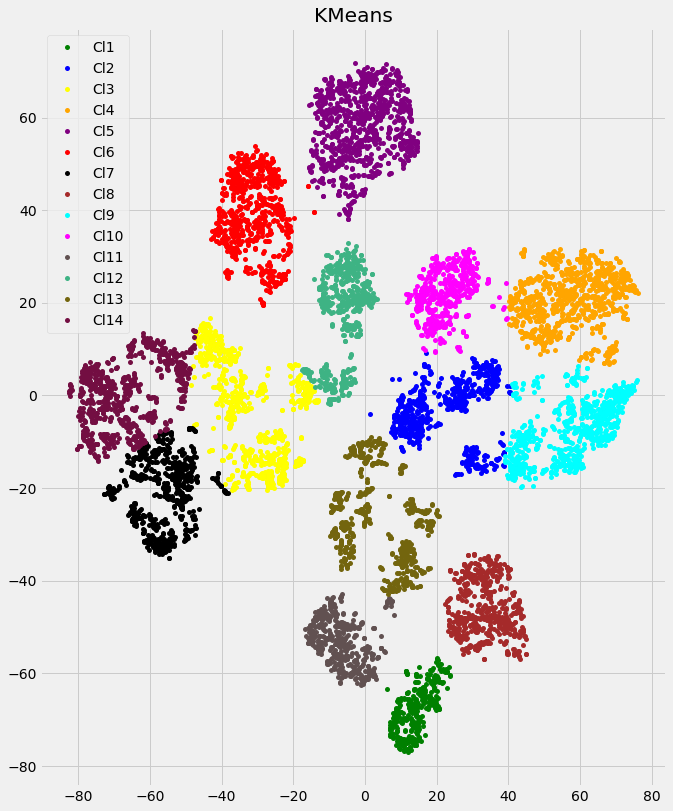

In [ ]:
for k in [4,6,10,12,14]:
  kmeans_groups = make_groups("KMeans", tsne_df, k)
  visualize(kmeans_groups, colors, lbls, "KMeans")

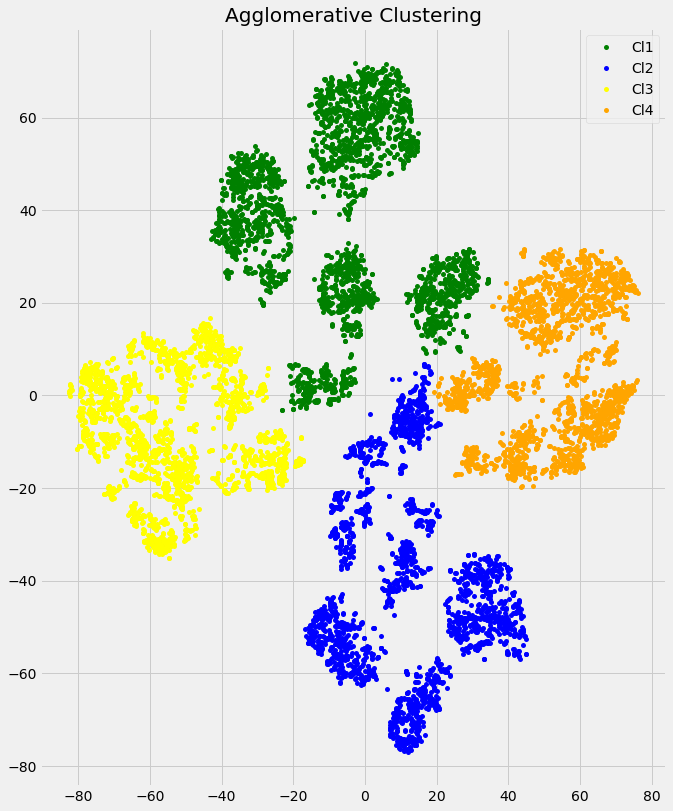

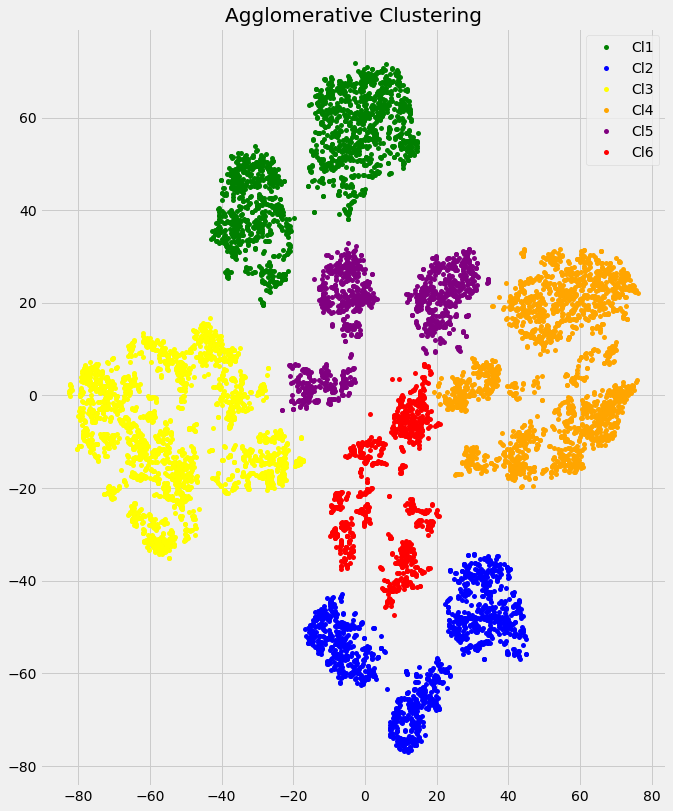

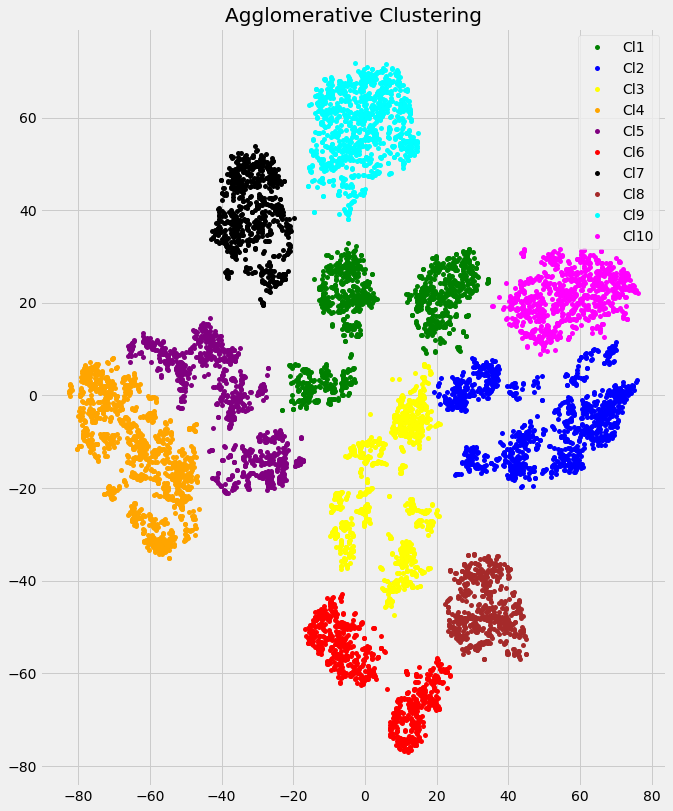

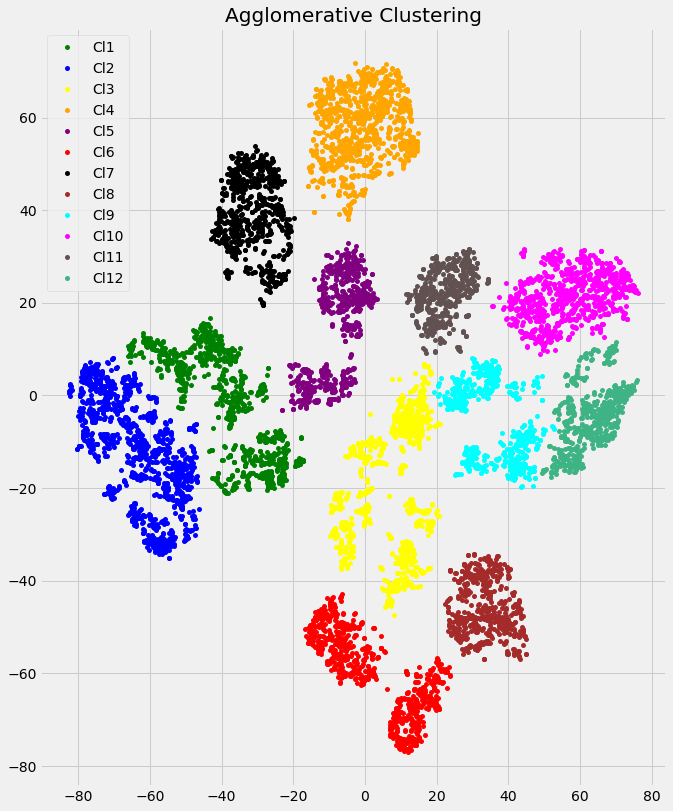

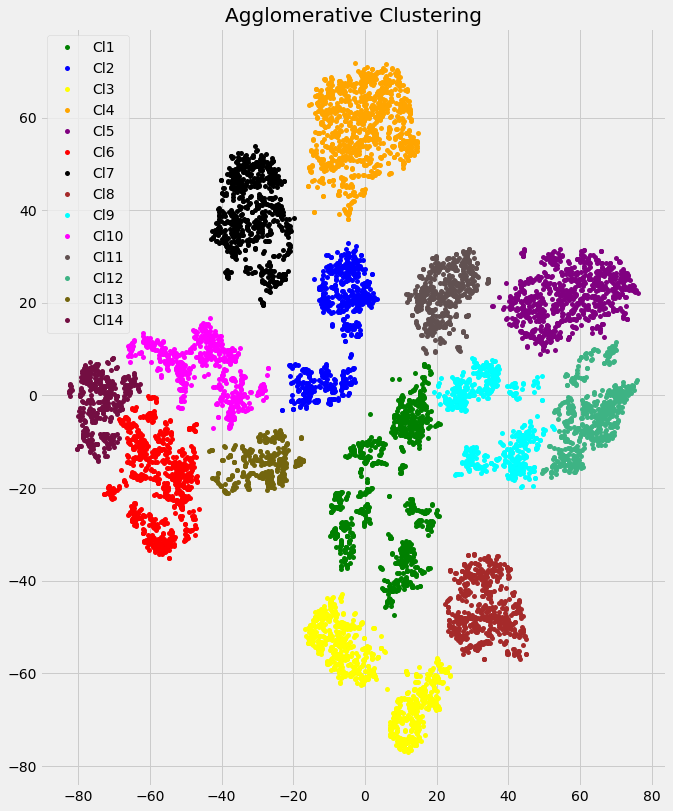

In [ ]:
for k in [4,6,10,12,14]:
  agl_groups = make_groups("Agglomerative Clustering", tsne_df, k)
  visualize(agl_groups, colors, lbls, "Agglomerative Clustering")

7. Для алгоритма DBSCAN необходимо выполнить шаги из пункта 6, однако подбор значений будет осуществляться по параметрам модели min_samples и eps. Найти наиболее оптимальное число кластеров за счёт этих параметров.

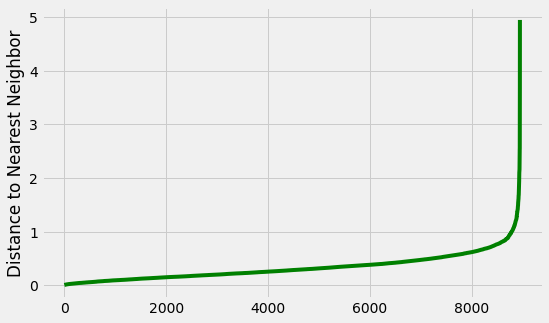

In [ ]:
def plot_distances(dataset, n):
  neighbors = NearestNeighbors(n_neighbors = n).fit(dataset)
  distances, *other = neighbors.kneighbors(dataset)
  distances = np.sort(distances, axis = 0)
  distances = distances[:, 1]
  plt.style.use('fivethirtyeight')
  plt.figure(figsize = (8, 5))
  plt.plot(distances, color = 'green')
  plt.ylabel('Distance to Nearest Neighbor')
  plt.show()
  return distances

distances = plot_distances(tsne_df, 2)

In [ ]:
kl = KneeLocator(range(len(distances)), distances, curve = 'convex', direction = 'increasing')
print(kl.elbow)
epsilon = distances[kl.elbow]
print(epsilon)

8888
1.2927206609482054


In [ ]:
scoeffs = []
eps=np.arange(0.1, 4, 0.2)
samples=np.arange(2,22,1)

for e, s in zip(eps, samples):
    dbscan = DBSCAN(eps=e, min_samples=s)
    dbscan.fit(tsne_df)
    score = silhouette_score(tsne_df, dbscan.labels_)
    print(f"Silhouette Coefficient {score} for {e} eps and {s} samples")
    scoeffs.append((score, e, s))

Silhouette Coefficient -0.7194955945014954 for 0.1 eps and 2 samples
Silhouette Coefficient -0.47819647192955017 for 0.30000000000000004 eps and 3 samples
Silhouette Coefficient -0.234823539853096 for 0.5000000000000001 eps and 4 samples
Silhouette Coefficient -0.04556462541222572 for 0.7000000000000001 eps and 5 samples
Silhouette Coefficient 0.06966205686330795 for 0.9000000000000001 eps and 6 samples
Silhouette Coefficient 0.08452733606100082 for 1.1000000000000003 eps and 7 samples
Silhouette Coefficient 0.1099928691983223 for 1.3000000000000003 eps and 8 samples
Silhouette Coefficient 0.12399056553840637 for 1.5000000000000004 eps and 9 samples
Silhouette Coefficient 0.17373624444007874 for 1.7000000000000004 eps and 10 samples
Silhouette Coefficient 0.18863436579704285 for 1.9000000000000004 eps and 11 samples
Silhouette Coefficient 0.2235579937696457 for 2.1000000000000005 eps and 12 samples
Silhouette Coefficient 0.2570759356021881 for 2.3000000000000007 eps and 13 samples
Silh

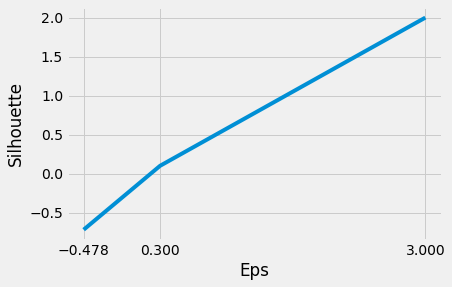

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(scoeffs[1], scoeffs[0])
plt.xticks(scoeffs[1])
plt.xlabel("Eps")
plt.ylabel("Silhouette")
plt.show()

In [ ]:
dbscan_groups = make_groups("DBSCAN", tsne_df)

Number of clusters: 13
Number of noise points: 52


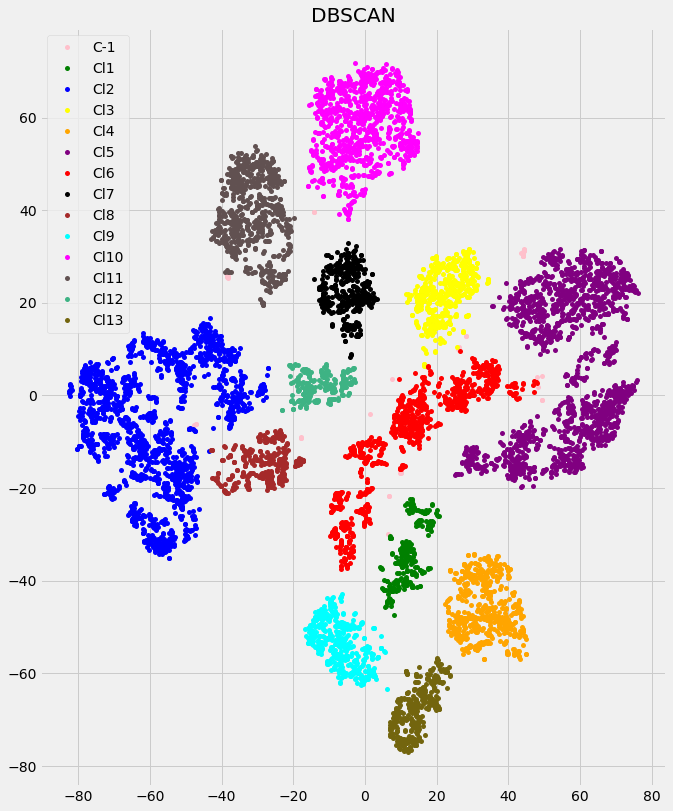

In [ ]:
visualize(dbscan_groups, colors, lbls, "DBSCAN")